# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import datetime as dt

# Conexão com o DB local

In [2]:
load_dotenv()

driver = os.environ["Driver"]
server = os.environ["Server"]
database = os.environ["Database"]

In [3]:
dados_conexao = (
    f"Driver={driver};"
    f"Server={server};"
    f"Database={database};"
)

In [4]:
def query_banco(query, dados_conexao):
    engine = create_engine(f'mssql+pyodbc:///?odbc_connect={dados_conexao}')
    return pd.read_sql(query, engine)

# Import dos dados

In [5]:
df_receitas = query_banco("SELECT * FROM Fato_Receita", dados_conexao)
df_receitas.drop(columns=['id','uid_fato_receita'], inplace=True)
df_receitas.rename(columns={'valor':'valor_receita'}, inplace=True)
df_receitas.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27


In [6]:
df_populacao = query_banco("SELECT * FROM Dim_Populacao", dados_conexao)
df_populacao.drop(columns=['id'], inplace=True)
df_populacao

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual
0,1991,51273,0,0,0,0
1,1992,51530,257,"0,5",0,0
2,1993,51965,435,"0,84",178,"69,26"
3,1994,52279,314,"0,6",-121,"-27,82"
4,1995,52586,307,"0,59",-7,"-2,23"
5,1996,51396,-1190,"-2,26",-1497,"-487,62"
6,1997,51575,179,"0,35",1369,"-115,04"
7,1998,51726,151,"0,29",-28,"-15,64"
8,1999,51878,152,"0,29",1,"0,66"
9,2000,54715,2837,"5,47",2685,"1766,45"


In [7]:
df_pib = query_banco("SELECT * FROM Dim_PIB", dados_conexao)
df_pib.drop(columns=['id'], inplace=True)
df_pib.rename(columns={'valor':'valor_pib'}, inplace=True)
df_pib

,ano,valor_pib
0,2006-01-01,342557000
1,2008-01-01,449804000
2,2010-01-01,545321000
3,2012-01-01,688504000
4,2014-01-01,904648000
5,2016-01-01,1039264000
6,2018-01-01,1064232000
7,2020-01-01,1134471000
8,2006-01-01,342557
9,2008-01-01,449804


# Feature engineering

## Inserindo colunas que tratam do tempo

In [8]:
def cria_colunas_tempo(df, coluna_data):
    df[coluna_data] = pd.to_datetime(df[coluna_data])
    df['ano_mes'] = df[coluna_data].dt.strftime('%Y-%m')
    df['ano'] = df[coluna_data].dt.strftime('%Y')
    return df

def transforma_data_em_ordinal(df, coluna_referencia):
    df['ano_mes_ordinal'] = pd.to_datetime(df[coluna_referencia])
    df['ano_mes_ordinal'] = df['ano_mes_ordinal'].map(dt.datetime.toordinal)
    return df

def transforma_coluna_em_datetime(df, coluna):
    df[coluna] = pd.to_datetime(df[coluna], format='%Y')
    return df

## Remoção de outliers

In [9]:
# Aplicação de IQR - Interquartile Range
def remove_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    print(f'Q1: {Q1}')
    Q3 = df[coluna].quantile(0.75)
    print(f'Q3: {Q3}')
    IQR = Q3 - Q1
    print(f'IQR: {IQR}')
    print(f'Limite inferior: {Q1 - 1.5 * IQR}')
    print(f'Limite superior: {Q3 + 1.5 * IQR}')
    df = df[(df[coluna] >= Q1 - 1.5*IQR) & (df[coluna] <= Q3 + 1.5*IQR)]
    print(f'Quantidade de registros sem outliers: {df.shape[0]}')
    return df

def box_plot(df, coluna_referencia, coluna_visao):
    print(f'Quantidade de registros: {df.shape[0]}')
    df.boxplot(by=coluna_referencia, column=coluna_visao, figsize=(10,6))

## Conversão de tipos de dados nas colunas

In [10]:
def converte_tipo_dados(df, colunas, tipo):
    for coluna in colunas:
        df[coluna] = df[coluna].astype(tipo)
    return df

# Análise exploratória dos dados

## Receitas

In [11]:
df_receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102293 entries, 0 to 102292
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cod_receita           102293 non-null  int64         
 1   data_fato             102293 non-null  datetime64[ns]
 2   contribuinte_receita  102293 non-null  object        
 3   valor_receita         102293 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [12]:
df_receitas.describe().round(2)

,cod_receita,data_fato,valor_receita
count,1.022930e+05,102293,102293.00
mean,1.256925e+09,2017-11-11 13:19:10.635918336,12522.46
min,1.112500e+08,2013-01-02 00:00:00,-2489288.55
25%,1.113034e+09,2015-07-16 00:00:00,51.23
50%,1.121250e+09,2017-10-13 00:00:00,240.60
75%,1.325000e+09,2020-02-05 00:00:00,1579.25
max,9.728013e+09,2022-12-30 00:00:00,4674330.00
std,1.162115e+09,NaN,89618.73


In [13]:
df_receitas_com_outliers = cria_colunas_tempo(df_receitas,'data_fato')
df_receitas_com_outliers.head()

,cod_receita,data_fato,contribuinte_receita,valor_receita,ano_mes,ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013-01,2013
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,2013-01,2013
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,2013-01,2013
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,2013-01,2013
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,2013-01,2013


Quantidade de registros: 102293


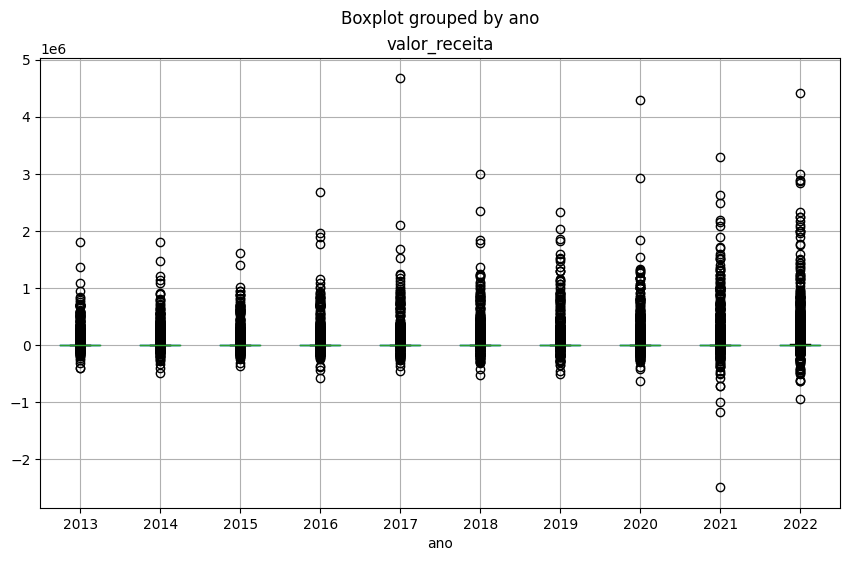

In [14]:
box_plot(df_receitas_com_outliers, 'ano', 'valor_receita')

In [15]:
df_receitas_sem_outliers = remove_outliers(df_receitas_com_outliers, 'valor_receita')

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


Quantidade de registros: 83736


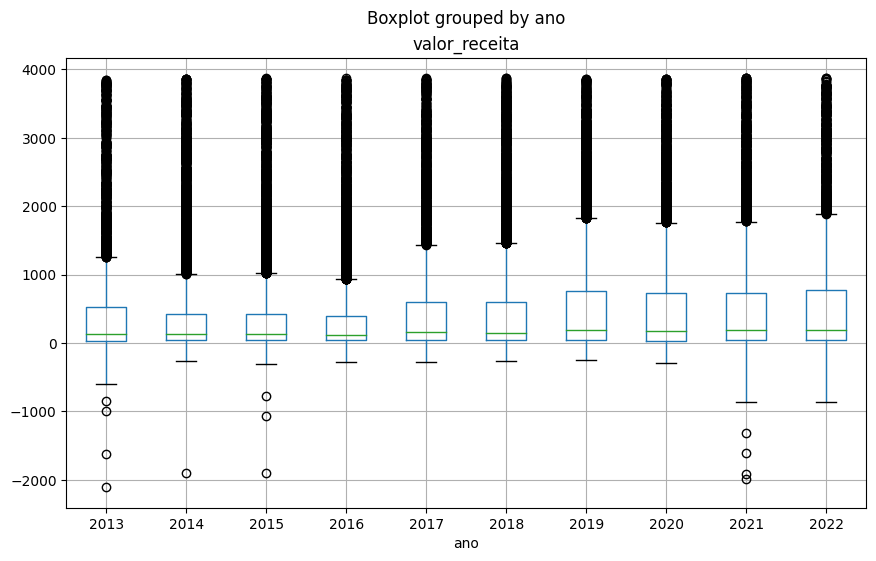

In [16]:
box_plot(df_receitas_sem_outliers, 'ano', 'valor_receita')

## População

In [17]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ano                                    32 non-null     int64 
 1   populacao                              32 non-null     int64 
 2   variacao_anual                         32 non-null     object
 3   porcentagem_variacao_anual             32 non-null     object
 4   aceleracao_variacao_anual              32 non-null     object
 5   porcentagem_aceleracao_variacao_anual  32 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.6+ KB


In [18]:
df_populacao.describe().round(0)

,ano,populacao
count,32.0,32.0
mean,2006.0,57024.0
std,9.0,4073.0
min,1991.0,51273.0
25%,1999.0,52509.0
50%,2006.0,57065.0
75%,2014.0,61130.0
max,2022.0,63239.0


In [19]:
df_populacao_dados_copy = df_populacao.copy()
df_populacao_dados_convertidos = df_populacao_dados_copy
df_populacao_dados_convertidos['ano'] = df_populacao_dados_convertidos['ano'].astype(object)
df_populacao_dados_convertidos = transforma_coluna_em_datetime(df_populacao, 'ano')
df_populacao_dados_convertidos = cria_colunas_tempo(df_populacao, 'ano')
df_populacao_dados_convertidos['porcentagem_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_variacao_anual'].str.replace(',','.').astype(float)
df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'].str.replace(',','.').astype(float)

In [20]:
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     object 
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     object 
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.9+ KB


In [21]:
df_populacao_dados_convertidos = converte_tipo_dados(df_populacao_dados_convertidos, ['variacao_anual', 'aceleracao_variacao_anual'], 'int64')
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ano                                    32 non-null     object 
 1   populacao                              32 non-null     int64  
 2   variacao_anual                         32 non-null     int64  
 3   porcentagem_variacao_anual             32 non-null     float64
 4   aceleracao_variacao_anual              32 non-null     int64  
 5   porcentagem_aceleracao_variacao_anual  32 non-null     float64
 6   ano_mes                                32 non-null     object 
dtypes: float64(2), int64(3), object(2)
memory usage: 1.9+ KB


In [22]:
df_populacao_dados_convertidos

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual,ano_mes
0,1991,51273,0,0.00,0,0.00,1991-01
1,1992,51530,257,0.50,0,0.00,1992-01
2,1993,51965,435,0.84,178,69.26,1993-01
3,1994,52279,314,0.60,-121,-27.82,1994-01
4,1995,52586,307,0.59,-7,-2.23,1995-01
5,1996,51396,-1190,-2.26,-1497,-487.62,1996-01
6,1997,51575,179,0.35,1369,-115.04,1997-01
7,1998,51726,151,0.29,-28,-15.64,1998-01
8,1999,51878,152,0.29,1,0.66,1999-01
9,2000,54715,2837,5.47,2685,1766.45,2000-01


## PIB

In [23]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ano        21 non-null     object
 1   valor_pib  21 non-null     object
dtypes: object(2)
memory usage: 468.0+ bytes


In [24]:
df_pib_convertidos = converte_tipo_dados(df_pib, ['valor_pib'], 'float')

In [25]:
# Estimar valores para os anos 2021 e 2022 usando a média das variações anuais
variacoes_anuais = df_pib_convertidos.groupby('ano')['valor_pib'].last().pct_change().mean()
valor_2020 = df_pib_convertidos['valor_pib'].values[-1]
valor_2021_estimado = valor_2020 * (1 + variacoes_anuais)
valor_2022_estimado = valor_2021_estimado * (1 + variacoes_anuais)

In [26]:
df_pib# Criar um novo DataFrame com as linhas para 2021 e 2022
novas_linhas = pd.DataFrame({'ano': [2021, 2022], 'valor_pib': [valor_2021_estimado, valor_2022_estimado]})
novas_linhas = transforma_coluna_em_datetime(novas_linhas, 'ano')

# Concatenar as novas linhas ao DataFrame original
df_pib_convertidos = pd.concat([df_pib_convertidos, novas_linhas], ignore_index=True)
df_pib_convertidos

,ano,valor_pib
0,2006-01-01,3.425570e+08
1,2008-01-01,4.498040e+08
2,2010-01-01,5.453210e+08
3,2012-01-01,6.885040e+08
4,2014-01-01,9.046480e+08
5,2016-01-01,1.039264e+09
6,2018-01-01,1.064232e+09
7,2020-01-01,1.134471e+09
8,2006-01-01,3.425570e+05
9,2008-01-01,4.498040e+05


In [31]:
df_pib_convertidos = cria_colunas_tempo(df_pib_convertidos, 'ano')

In [32]:
df_pib_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ano        23 non-null     object 
 1   valor_pib  23 non-null     float64
 2   ano_mes    23 non-null     object 
dtypes: float64(1), object(2)
memory usage: 684.0+ bytes


In [33]:
df_pib_convertidos

,ano,valor_pib,ano_mes
0,2006,3.425570e+08,2006-01
1,2008,4.498040e+08,2008-01
2,2010,5.453210e+08,2010-01
3,2012,6.885040e+08,2012-01
4,2014,9.046480e+08,2014-01
5,2016,1.039264e+09,2016-01
6,2018,1.064232e+09,2018-01
7,2020,1.134471e+09,2020-01
8,2006,3.425570e+05,2006-01
9,2008,4.498040e+05,2008-01


# Preparo dos df para implementação dos modelos de RN

## Dados da receita + população + pib

In [30]:
df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)
df_populacao_dados_convertidos.drop(columns=['porcentagem_variacao_anual', 'porcentagem_aceleracao_variacao_anual','ano_mes'], inplace=True)
df_pib_convertidos.drop(columns=['ano_mes'], inplace=True)

C:\Users\allys\AppData\Local\Temp\ipykernel_17524\3075247237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_receitas_sem_outliers.drop(columns=['cod_receita','contribuinte_receita'], inplace=True)


KeyError: "['ano_mes'] not found in axis"

In [ ]:
df_receitas_agrupado = df_receitas_sem_outliers.groupby(['ano', 'ano_mes'])['valor_receita'].sum().reset_index()
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_populacao_dados_convertidos, on='ano', how='left')
df_receitas_agrupado = pd.merge(df_receitas_agrupado, df_pib_convertidos, on='ano', how='left')
df_receitas_agrupado

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib
0,2013,2013-01,160122.33,60612,1482,1146,770339.0
1,2013,2013-02,125630.52,60612,1482,1146,770339.0
2,2013,2013-03,169281.06,60612,1482,1146,770339.0
3,2013,2013-04,161371.68,60612,1482,1146,770339.0
4,2013,2013-05,158982.66,60612,1482,1146,770339.0
...,...,...,...,...,...,...,...
163,2022,2022-08,232355.13,63239,663,376,NaN
164,2022,2022-09,198234.65,63239,663,376,NaN
165,2022,2022-10,185469.57,63239,663,376,NaN
166,2022,2022-11,207671.22,63239,663,376,NaN


### Elaborando metadados

#### Sample dos dados

In [ ]:
# sample dos dados para as receitas mensais do município
df_receitas_agrupado['SMA(12)'] = df_receitas_agrupado['valor_receita'].rolling(window=12).mean()
df_receitas_agrupado['SMA(6)'] = df_receitas_agrupado['valor_receita'].rolling(window=6).mean()
df_receitas_agrupado['SMA(3)'] = df_receitas_agrupado['valor_receita'].rolling(window=3).mean()
df_receitas_agrupado['SMA(2)'] = df_receitas_agrupado['valor_receita'].rolling(window=2).mean()
df_receitas_agrupado['lag(12)'] = df_receitas_agrupado['valor_receita'].shift(12)
df_receitas_agrupado['lag(6)'] = df_receitas_agrupado['valor_receita'].shift(6)
df_receitas_agrupado['lag(4)'] = df_receitas_agrupado['valor_receita'].shift(4)
df_receitas_agrupado['lag(3)'] = df_receitas_agrupado['valor_receita'].shift(3)
df_receitas_agrupado['lag(2)'] = df_receitas_agrupado['valor_receita'].shift(2)
df_receitas_agrupado['lag(1)'] = df_receitas_agrupado['valor_receita'].shift(1)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,NaN,NaN,NaN,142876.425,NaN,NaN,NaN,NaN,NaN,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,NaN,NaN,151677.97,147455.790,NaN,NaN,NaN,NaN,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,NaN,NaN,152094.42,165326.370,NaN,NaN,NaN,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,NaN,NaN,163211.80,160177.170,NaN,NaN,160122.33,125630.52,169281.06,161371.68


In [ ]:
df_receitas_agrupado['SMA(12)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(6)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(3)'].fillna(0, inplace=True)
df_receitas_agrupado['SMA(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(12)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(6)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(4)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(3)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(2)'].fillna(0, inplace=True)
df_receitas_agrupado['lag(1)'].fillna(0, inplace=True)
df_receitas_agrupado.head()

,ano,ano_mes,valor_receita,populacao,variacao_anual,aceleracao_variacao_anual,valor_pib,SMA(12),SMA(6),SMA(3),SMA(2),lag(12),lag(6),lag(4),lag(3),lag(2),lag(1)
0,2013,2013-01,160122.33,60612,1482,1146,770339.0,0.0,0.0,0.00,0.000,0.0,0.0,0.00,0.00,0.00,0.00
1,2013,2013-02,125630.52,60612,1482,1146,770339.0,0.0,0.0,0.00,142876.425,0.0,0.0,0.00,0.00,0.00,160122.33
2,2013,2013-03,169281.06,60612,1482,1146,770339.0,0.0,0.0,151677.97,147455.790,0.0,0.0,0.00,0.00,160122.33,125630.52
3,2013,2013-04,161371.68,60612,1482,1146,770339.0,0.0,0.0,152094.42,165326.370,0.0,0.0,0.00,160122.33,125630.52,169281.06
4,2013,2013-05,158982.66,60612,1482,1146,770339.0,0.0,0.0,163211.80,160177.170,0.0,0.0,160122.33,125630.52,169281.06,161371.68
